In [28]:
import cv2 #opencv-python
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.optimizers import SGD
import h5py
import datetime
import os
from func import *

train_dir = "data/train"
test_dir = "data/test"
df = pd.read_csv("data/labels.csv")
display(df.head())

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Nombre de photos des différentes races de chiens


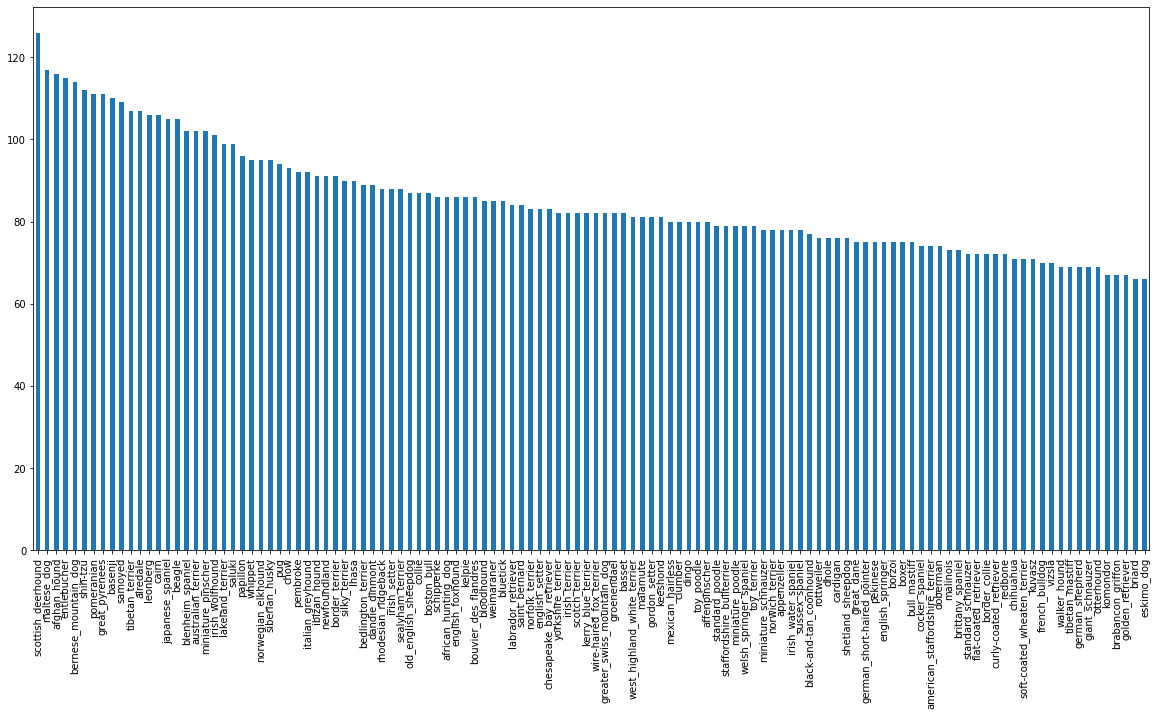

In [29]:
print("Nombre de photos des différentes races de chiens")
df["breed"].value_counts().plot.bar(figsize=(20, 10));

In [30]:
{'nombre totale de chiens': df.shape[0], 'nombre de chiens de race la plus représentée': df["breed"].value_counts()[0], 'nombre de chiens de race la moins représentée': df["breed"].value_counts()[-1]}

{'nombre totale de chiens': 10222,
 'nombre de chiens de race la plus représentée': 126,
 'nombre de chiens de race la moins représentée': 66}

In [31]:
max_breed = df["breed"].value_counts().index[0]
min_breed = df["breed"].value_counts().index[-1]

Il y a **10222 images** représentant **120 races** de chiens, la moins représentées est **eskimo_dog avec 66 images** et la plus représentées est **scottish deehound avec 126 images**. Notre jeu de données est suffisant plutôt faible ce qui risque d'entrainer du suraprentissage et nos classes sont désiquilibrées, on pourra palier à ces deux problèmes avec différentes techniques notemment l'augmentation.

In [32]:
df['path'] = df.id.apply(lambda x: 'data/train/{}.jpg'.format(x))

In [33]:
from IPython.display import display, Image
random_max_breed = df.query("breed == @max_breed").sample()
random_min_breed = df.query("breed == @min_breed").sample()

La classe la plus représentée : scottish_deerhound (126 images)


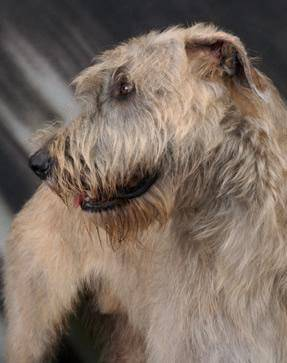

In [34]:
print("La classe la plus représentée : {} ({} images)".format(max_breed, df["breed"].value_counts()[0]))
Image(random_max_breed.path.item())

La classe la moins représentée : eskimo_dog (66 images)


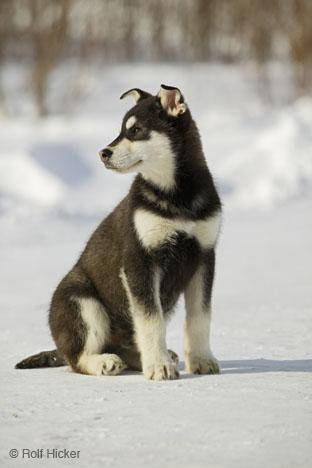

In [35]:
print("La classe la moins représentée : {} ({} images)".format(min_breed, df["breed"].value_counts()[-1]))
Image(random_min_breed.path.item())

**Effectif de chaque race de chien**

In [36]:
pd.DataFrame(df.breed.value_counts())

,breed
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
komondor,67
brabancon_griffon,67
golden_retriever,67
briard,66


### Vérification des données

In [37]:
from os import listdir
from os.path import isfile, join
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


sample_submission = pd.read_csv('data/sample_submission.csv')

def get_all_files_in_dir(dir_path, full_path=True):
    if full_path:
        return [dir_path+f for f in listdir(dir_path) if isfile(join(dir_path, f))]
    else:
        return [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
    
train_image_paths = get_all_files_in_dir('data/train/')
test_image_paths = get_all_files_in_dir('data/test/')
md(f'Il y a **{len(train_image_paths):,}** images dans notre dossier train')
md(f'Il y a **{len(test_image_paths):,}** images dans notre dossier test')
if df.shape[0] != len(train_image_paths) or sample_submission.shape[0] != len(test_image_paths):
    print("/!\ Il y a une différence entre le nombre d'image est le nombre de lignes dans notre dataset!")
else:
    print("Il y autant d'images dans nos dossiers que de ligne dans nos fichiers de train et de test.")
    

def get_img_infos(img):
    img_type = type(img)
    img_format = img.format
    img_mode = img.mode
    img_size = img.size
    return img_type, img_format, img_mode, img_size

sample_image = load_img(train_image_paths[0])
sample_type, sample_format, sample_mode, sample_size = get_img_infos(sample_image)



bad_img_count = 0
for image_paths in (train_image_paths, test_image_paths):
    for img_path in image_paths:
        img = load_img(img_path)
        img_type, img_format, img_mode, img_size = get_img_infos(img)
        if img_type != sample_type or img_format != sample_format or img_mode != sample_mode:
            print("L'image n'est pas conforme : {}".format(img_path))
            bad_img_count += 1
        
if bad_img_count == 0:
    md("**Toutes les images sont conformes**")
else:
    print("{} image(s) doivent être ajustées".format(bad_img_count))
    




Il y a **10,222** images dans notre dossier train

Il y a **10,357** images dans notre dossier test

Il y autant d'images dans nos dossiers que de ligne dans nos fichiers de train et de test.


**Toutes les images sont conformes**

Voici une image pris au hasard:
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Image format: JPEG
Image mode: RGB
Image size: (500, 375)


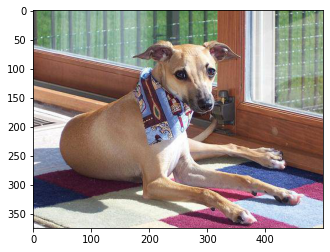

In [38]:
print("Voici une image pris au hasard:")
plt.imshow(sample_image_array / 255.0);
print('Image type: {}'.format(sample_type))
print('Image format: {}'.format(sample_format))
print('Image mode: {}'.format(sample_mode))
print('Image size: {}'.format(sample_size))

In [39]:
print("Pour pouvoir travailler avec des images on doit les convertir en chiffre c'est à dire en matrice. Chaque pixel devient un vecteur de taille 3 codant les couleurs RGB (red, green, blue)")
print('Transformation en matrice...')
sample_image_array = img_to_array(sample_image)
print(f'Image type: {type(sample_image_array)}')
print(f'Image array shape: {sample_image_array.shape}')
sample_image_array

Pour pouvoir travailler avec des images on doit les convertir en chiffre c'est à dire en matrice. Chaque pixel devient un vecteur de taille 3 codant les couleurs RGB (red, green, blue)
Transformation en matrice...
Image type: <class 'numpy.ndarray'>
Image array shape: (375, 500, 3)


array([[[ 68.,  70.,  67.],
        [ 75.,  75.,  73.],
        [ 90.,  88.,  89.],
        ...,
        [164., 197., 168.],
        [131., 164., 135.],
        [122., 155., 126.]],

       [[ 65.,  67.,  64.],
        [ 72.,  72.,  70.],
        [ 87.,  85.,  86.],
        ...,
        [152., 185., 154.],
        [136., 169., 138.],
        [134., 167., 136.]],

       [[ 67.,  69.,  66.],
        [ 73.,  73.,  71.],
        [ 88.,  86.,  87.],
        ...,
        [137., 168., 136.],
        [139., 170., 138.],
        [144., 175., 143.]],

       ...,

       [[218., 218., 220.],
        [224., 224., 226.],
        [235., 235., 237.],
        ...,
        [239., 231., 208.],
        [237., 229., 206.],
        [235., 227., 204.]],

       [[202., 202., 204.],
        [206., 206., 208.],
        [217., 217., 219.],
        ...,
        [245., 236., 207.],
        [244., 235., 206.],
        [243., 234., 205.]],

       [[199., 199., 201.],
        [198., 198., 200.],
        [208., 2